# Use case Schouwen Westkop Noord

## 1. Import functionality

In [1]:
from functions import *

## 3. User defined values

In [2]:
load_factor =np.array([0,0.1,0.2,0.3, 0.4,0.5,0.6,0.7,0.8,0.9,1]) # Roadmap11

start = [3.674, 51.70969009]                          # Location of the koppelpunt                             (lon, lat)
stop = [3.522637481591586,51.76880095558772]          # Location of the dredging area                          (lon, lat)
Volume = 200_000                                       # Total volume to be dregded                             (m^3)


unloading_rate = 1.5
loading_rate = 1.5
ukc = 1.0                                             # Under Keel clearance                                   (m)
WWL = 20                                              # Width on Water Line                                    (m)
LWL = 80                                              # Length on Water Line                                   (m)
hopper_capacity = 4000                                # Maximal capacity of the hopper                         (m^3)
V_full = 10*0.514444444                               # Velocity in deep water when maximal loaded             (m/s)
V_emp = 12*0.514444444                                # Maximal sailing velocity empty in deep water           (m/s)
T_full = 6.5                                           # Draft when maximal Loaded                              (m)
T_emp = 3.5                                             # Draft When empty                                       (m)
WVPI_full = 10000                                     # Weight when maximal loaded                             (tf)
WVPI_empt = 4000                                      # Weight empty (tf)

Q_cost = compute_cost(700_000, 0.008)                 # Cost function for route optimizer                      ($)
Q_co2 = compute_co2(1)                                # Cost function for route optimizer                      (g CO2)
Q_velo = compute_v_provider(V_emp, V_full)            # Vessel velocity is dependent on load factor


service_hours = 168                                   # hours per week
delay_for_bunkering = 10                              # hours per week
technical_delay = 10                                  # hours per week
project_related_delay = 3                             # hours per week

load_factor

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

## 4. Digital-twin simulation

In [3]:
nl = (0.5,1.5)
dx_min = 0.02
blend = 0.8
number_of_neighbor_layers = 1

vship =np.transpose([interpolate(load_factor, V_full, V_emp)])

WD_min= interpolate(load_factor, T_full, T_emp)
WVPI  = interpolate(load_factor, WVPI_full, WVPI_empt)

Load_flow = flow_class.flow_tides
name_textfile_flow = 'D:/Use_case_Schouwen/flow_route2'

start_time = time.time()

Roadmap   = Mesh_maker.Graph_flow_model(name_textfile_flow, 
                                        dx_min, 
                                        blend, 
                                        nl, 
                                        number_of_neighbor_layers, 
                                        vship, 
                                        Load_flow, 
                                        WD_min,
                                        WVPI,
                                        WWL = WWL,
                                        ukc = ukc,
                                        compute_cost = Q_cost,
                                        compute_co2 = Q_co2,
                                        repeat = True,
                                        nodes_index = np.arange(58),
                                        optimization_type=['time']
                                       )

stop_time = time.time()
computation_time = stop_time - start_time
print("the computational time is:", round(computation_time,2), "sec")

halem.save_object(Roadmap, 'Roadmap11SIM')

4/4
the computational time is: 10.73 sec


In [4]:
# name_textfile_load = 'Roadmaptest'

# with open(name_textfile_load, 'rb') as input:
#     Roadmap = pickle.load(input)

In [5]:
start_time_tot = time.time()


t0 = '15/04/2019 01:00:00'                            # start of the simulation                                (string)
d = datetime.datetime.strptime(t0, "%d/%m/%Y %H:%M:%S")
t0 = d.timestamp()
simulation_start = datetime.datetime.fromtimestamp(t0)
my_env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
my_env.epoch = time.mktime(simulation_start.timetuple())

TransportProcessingResource = type('TransportProcessingResource', 
                                   (core.Identifiable,              # Give it a name
                                    core.Log,                       # Allow logging of all discrete events
                                    core.ContainerDependentMovable, # A moving container, so capacity and location
                                    core.Processor,                 # Allow for loading and unloading
                                    core.HasResource,               # Add information on serving equipment
                                    core.Routeable,                 # Route is optimized
                                    core.LoadingFunction,           # Add a loading function
                                    core.UnloadingFunction,         # Add an unloading function
                                   ),
                                   {})
data_from_site = {"env": my_env,                  # The simpy environment defined in the first cel
                  "name": "Winlocatie",           # The name of the site
                  "geometry": [],                 # The coordinates of the project site
                  "capacity": Volume,            # The capacity of the site
                  "level": Volume}               # The actual volume of the site

data_node = {"env": my_env,                      # The simpy environment defined in the first cel
                 "name": "Intermediate site",     # The name of the site
                 "geometry": []}                  # The coordinates of the project site

data_to_site = {"env": my_env,                    # The simpy environment defined in the first cel
                "name": "Dumplocatie",            # The name of the site
                "geometry": [],                   # The coordinates of the project site
                "capacity": Volume,              # The capacity of the site
                "level": 0}                       # The actual volume of the site (empty of course)

path = [start, stop]
Nodes, Edges = connect_sites_with_path(data_from_site, data_to_site, data_node, path)
positions = {}
FG = nx.Graph()
my_env.FG = FG

for node in Nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)
for edge in Edges:
    FG.add_edge(edge[0].name, edge[1].name, weight = 1)
route = []
data_hopper = {"env": my_env,                                       # The simpy environment 
               "name": "Hopper 01",                                 # Name
               "geometry": Nodes[0].geometry,                       # It starts at the "from site"
               "loading_rate": loading_rate,                        # Loading rate
               "unloading_rate": unloading_rate,                    # Unloading rate
               "capacity": hopper_capacity,                         # Capacity of the hopper - "Beunvolume"
               "compute_v": Q_velo,                                 # Variable speed
               "route": route,
               "optimize_route": True,                              # Optimize the Route
               "optimization_type": 'time',                          # Optimize for the fastest path
               "loadfactors": load_factor

              }

hopper = TransportProcessingResource(**data_hopper)

activity = model.Activity(env = my_env,             # The simpy environment defined in the first cel
                          name = "Soil movement",   # We are moving soil
                          origin = Nodes[0],        # We originate from the from_site
                          destination = Nodes[-1],  # And therefore travel to the to_site
                          loader = hopper,          # The benefit of a TSHD, all steps can be done
                          mover = hopper,           # The benefit of a TSHD, all steps can be done
                          unloader = hopper,        # The benefit of a TSHD, all steps can be done
                          start_event = None,       # We can start right away
                          stop_event = None)        # We stop once there is nothing more to move

my_env.Roadmap = Roadmap
my_env.print_progress = True

my_env.run()
stop_time_tot = time.time()
computation_time_tot = stop_time_tot - start_time_tot
print("the Total computational time is:",int(computation_time_tot/60),'minutes and', np.round(computation_time_tot- int(computation_time_tot/60)*60,2) , "sec")

98.0 %
the Total computational time is: 0 minutes and 12.5 sec


## 7. Postprocessing

In [6]:
number_of_cycles = 0

for M in hopper.log['Message']:
    if M == 'loading start':
        number_of_cycles += 1

Operational_hours = service_hours - delay_for_bunkering - technical_delay - project_related_delay
efficiency = Operational_hours / service_hours
Total_production = Operational_hours/(((my_env.now - my_env.epoch)/ number_of_cycles/60) / 60) * (Volume / number_of_cycles)

vessels = [hopper]

activities = ['loading', 'unloading', 'sailing filled', 'sailing empty']
colors = {0:'rgb(55,126,184)', 1:'rgb(255,150,0)', 2:'rgb(98, 192, 122)', 3:'rgb(98, 141, 122)'}

Number of cycles 55
Project finished in 9 days, 10:53:05
m^3 per uur 882.0
m^3 per week 148093.0
Avaraged volume per cycle 3636.36
Avaraged minutes per cycle 247.51
Used load factors: {0.0, 1.0, 0.8, 0.7}

Production included downtime [m^3 / week]: 127818.09
Improvement over old method: 35.39 %


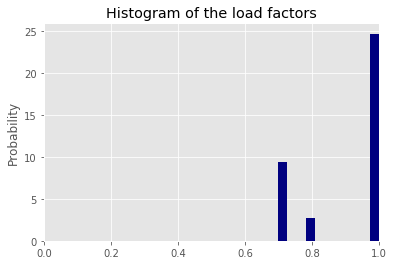

In [13]:
print('Number of cycles', number_of_cycles)
print("Project finished in {}".format(datetime.timedelta(seconds=int(my_env.now - my_env.epoch))))
print("m^3 per uur",np.round(Volume/(my_env.now - my_env.epoch) * 60 * 60))
print("m^3 per week",np.round(Volume/(my_env.now - my_env.epoch) * 60 * 60 * 7 * 24))   
print('Avaraged volume per cycle', np.round(Volume / number_of_cycles, 2))
print('Avaraged minutes per cycle', np.round((my_env.now - my_env.epoch)/ number_of_cycles/60, 2)) 
print('Used load factors:',set(np.round(np.array(hopper.log['Value'])/ hopper_capacity, 2)))
print()
print('Production included downtime [m^3 / week]:',np.round(Total_production,2))
print('Improvement over old method:', np.round((Total_production / 94407.14 - 1)*100 ,2), '%' )

VV = [hopper.log['Value'][0]]
for V in hopper.log['Value']:
    if V != VV[-1]:
        VV.append(V)
        
VV = np.array(VV)[np.array(VV) > 0]

H = VV/ hopper_capacity
np.savetxt('hist', H)

plt.figure
ax = plt.subplot()
plt.hist(H, bins=11, density=True, color = 'navy' ) 
plt.ylabel('Probability')
plt.title('Histogram of the load factors')
plt.xlim(0, 1)
plt.show()

In [8]:
plot.vessel_planning(vessels, activities, colors)

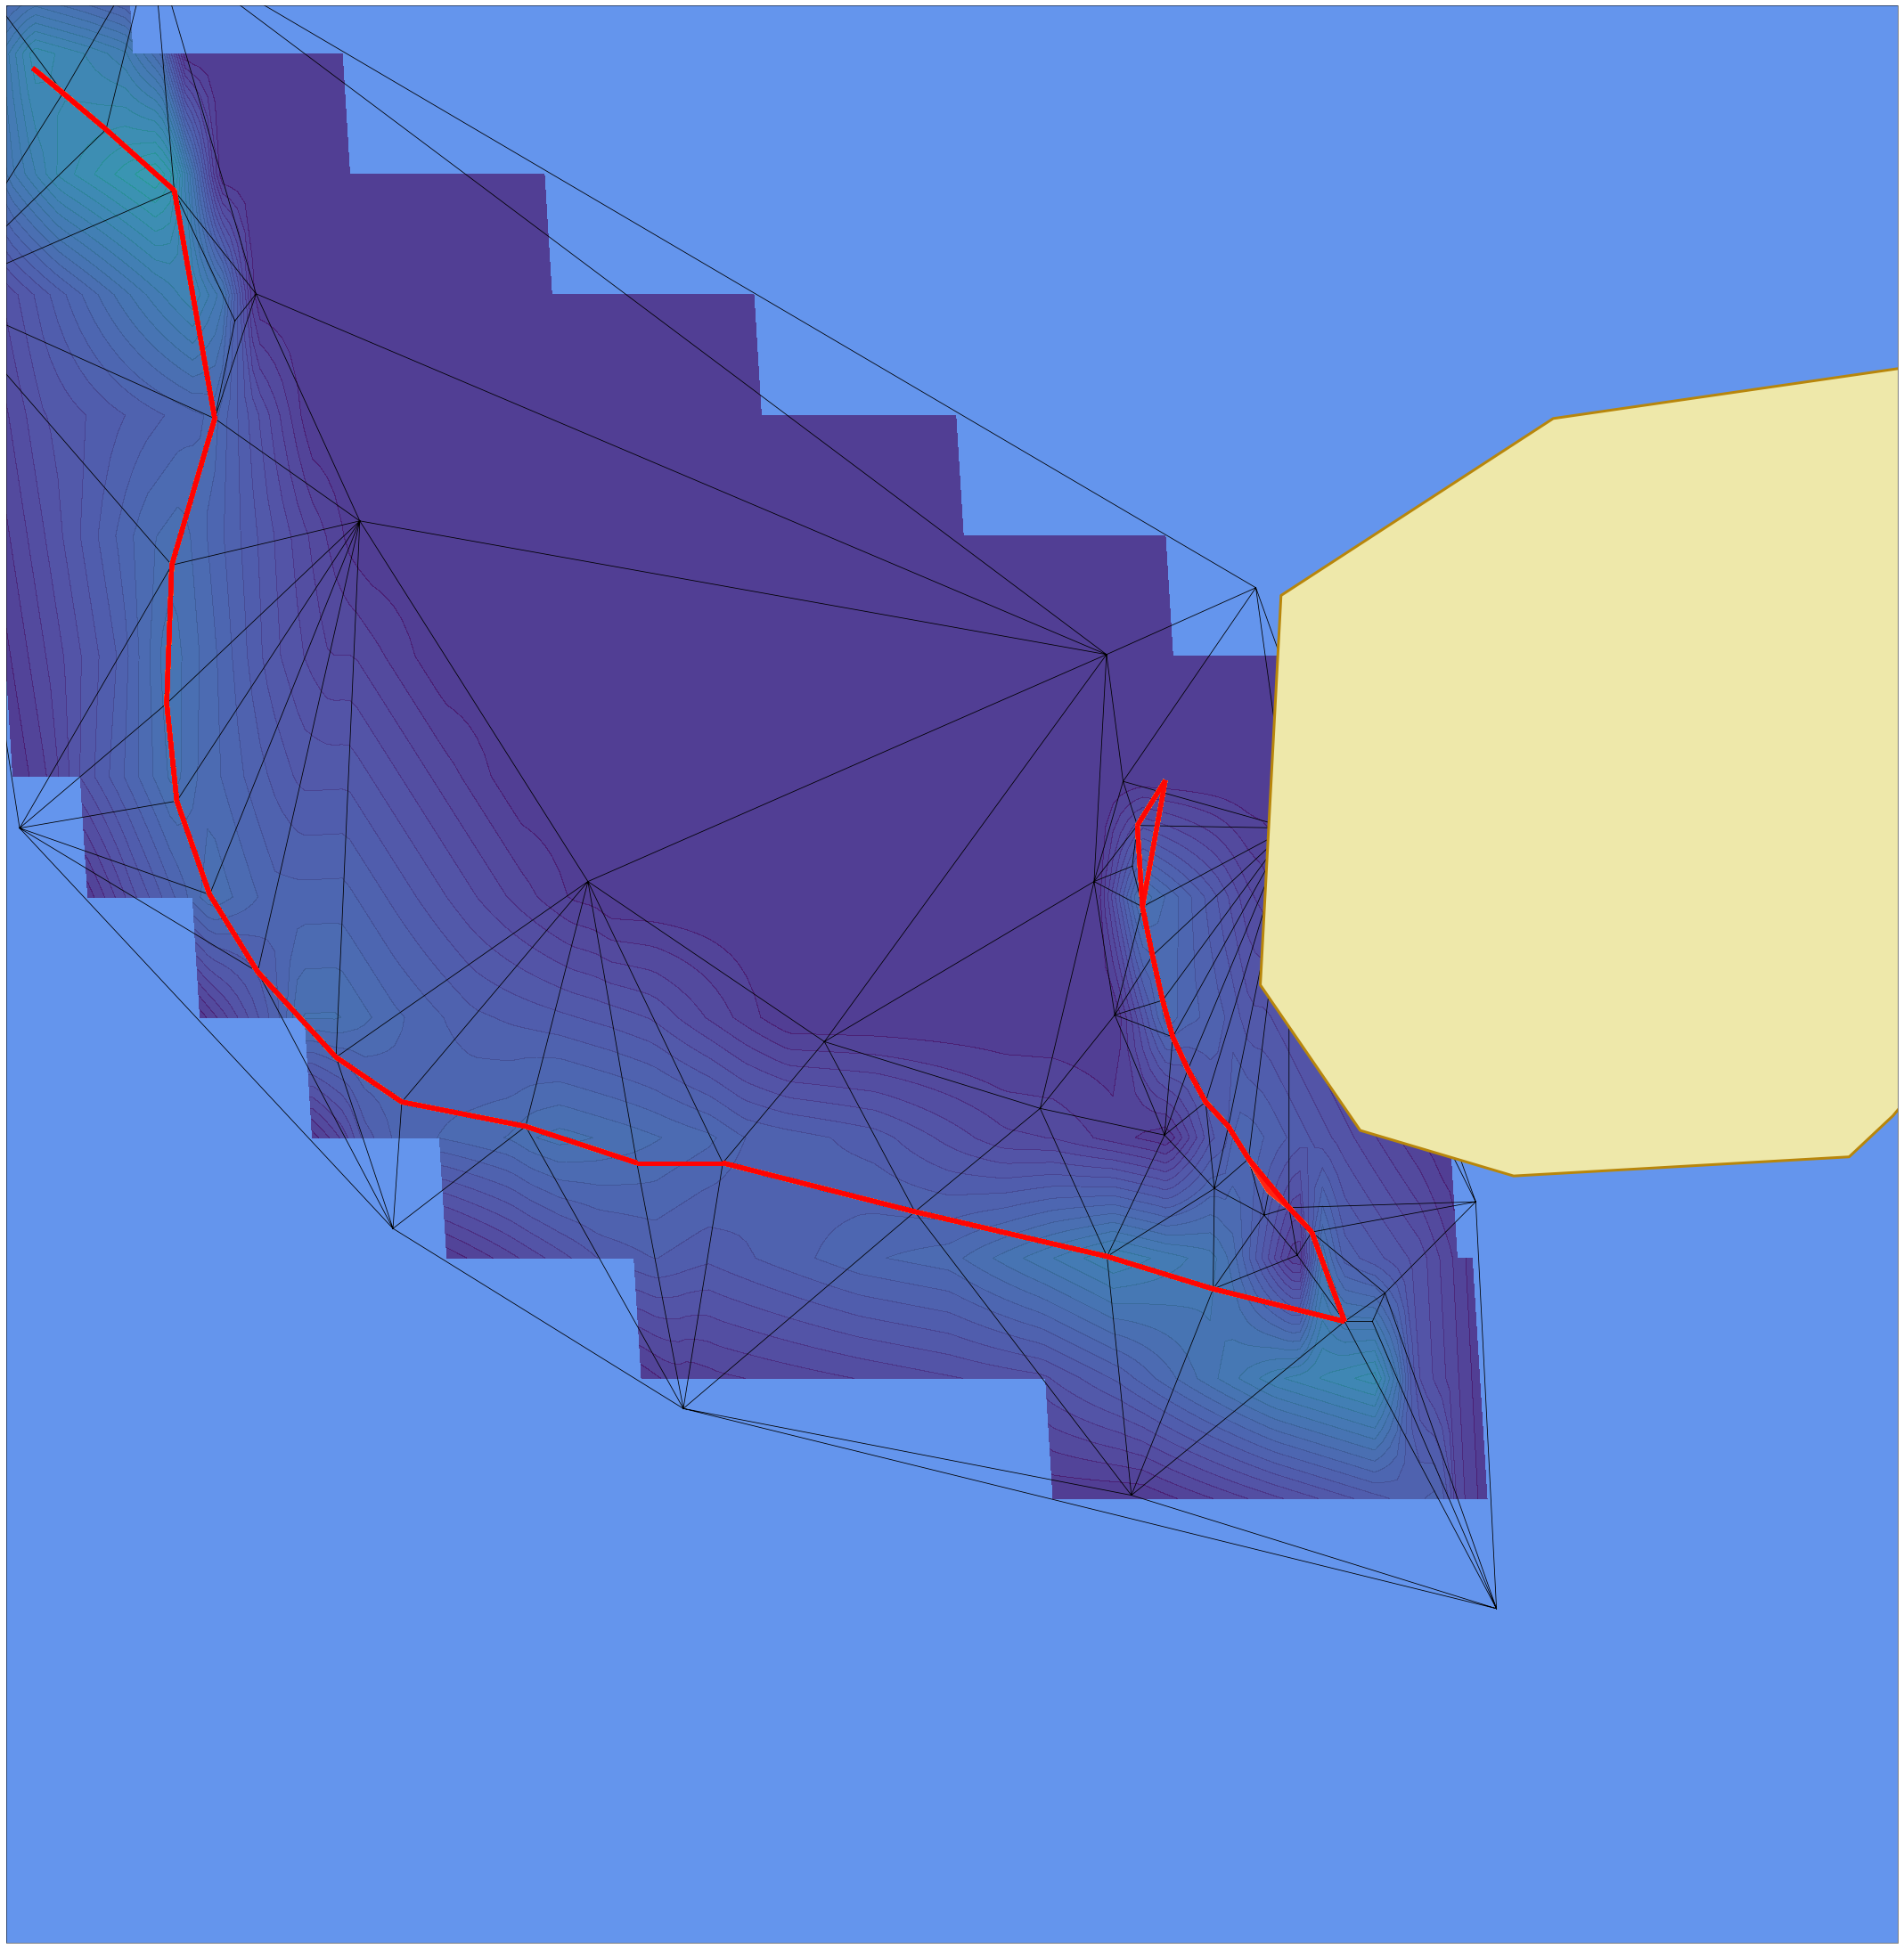

In [9]:
plot_route(hopper, Roadmap)

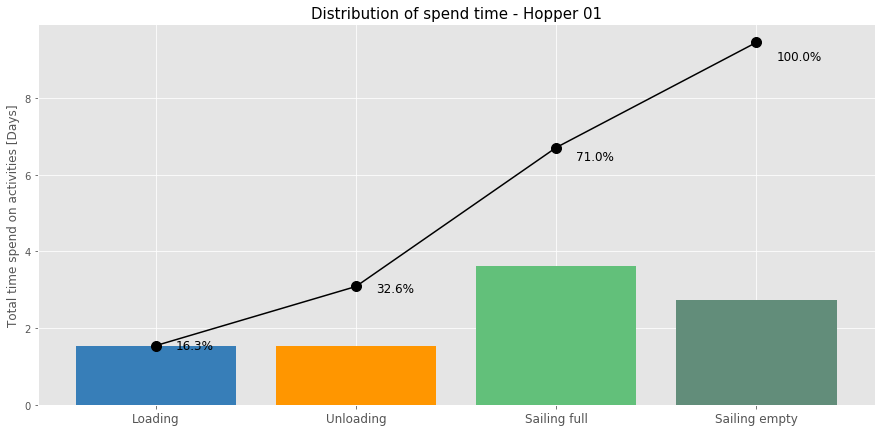

In [14]:
vessel = hopper
testing=False

activities = ['loading', 'unloading', 'sailing filled', 'sailing empty']
activities_times = [0, 0, 0, 0]

for i, activity in enumerate(activities):
    starts = []
    stops = []

    for j, message in enumerate(vessel.log["Message"]):
        if message == activity + " start":
            starts.append(vessel.log["Timestamp"][j])
        if message == activity + " stop":
            stops.append(vessel.log["Timestamp"][j])

    for j, _ in enumerate(starts):
        activities_times[i] += (stops[j] - starts[j]).total_seconds() / (3600 * 24)

loading, unloading, sailing_full, sailing_empty = (
    activities_times[0],
    activities_times[1],
    activities_times[2],
    activities_times[3],
)

# For the total plot
fig, ax1 = plt.subplots(figsize=[15, 7])

# For the barchart
height = [loading, unloading, sailing_full, sailing_empty]
labels = ["Loading", "Unloading", "Sailing full", "Sailing empty"]
colors = [
    (55 / 255, 126 / 255, 184 / 255),
    (255 / 255, 150 / 255, 0 / 255),
    (98 / 255, 192 / 255, 122 / 255),
    (98 / 255, 141 / 255, 122 / 255),
]

positions = np.arange(len(labels))
ax1.bar(positions, height, color=colors)

# For the cumulative percentages
total = sum([loading, unloading, sailing_full, sailing_empty])

unloading += loading
sailing_full += unloading
sailing_empty += sailing_full
y = [loading, unloading, sailing_full, sailing_empty]
n = [
    loading / total,
    unloading / total,
    sailing_full / total,
    sailing_empty / total,
]

ax1.plot(positions, y, "ko", markersize=10)
ax1.plot(positions, y, "k")

for i, txt in enumerate(n):
    x_txt = positions[i] + 0.1
    y_txt = y[i] * 0.95
    ax1.annotate("{:02.1f}%".format(txt * 100), (x_txt, y_txt), size=12)

# Further markup
plt.ylabel("Total time spend on activities [Days]", size=12)
ax1.set_xticks(positions)
ax1.set_xticklabels(labels, size=12)
plt.title("Distribution of spend time - {}".format(vessel.name), size=15)

if testing == False:
    plt.show()
    
np.savetxt('n', n)

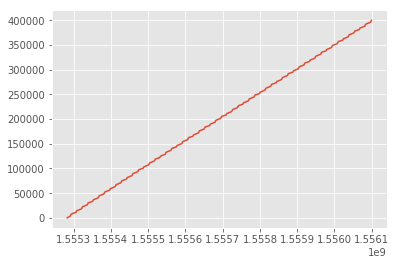

In [11]:
m3 = [0]
t = [Nodes[0].log['Timestamp'][0].timestamp()]
for i in range(len(Nodes[-1].log['Value'])):
    m3.append(Nodes[-1].log['Value'][i] + m3[-1])
    t.append(Nodes[-1].log['Timestamp'][i].timestamp())
plt.plot(t, m3)

np.savetxt('outputbase.csv',(m3,t))

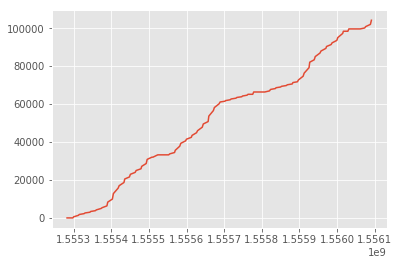

In [12]:
coord = []
for i in range(len(Nodes[0].log['Value'])):
    coord.append((hopper.log['Geometry'][i].x, hopper.log['Geometry'][i].y))
dist = [0]
t = [Nodes[0].log['Timestamp'][0].timestamp()]
D = 0
for i in range(1, len(coord)):
    D += halem.Functions.haversine(coord[i-1], coord[i])
    dist.append(D)
    t.append(Nodes[0].log['Timestamp'][i].timestamp())
plt.plot(t,dist)
np.savetxt('outputbase2.csv',(dist,t))